### Author: Aashish Singh

### About Dataset
Context
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]

Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

### Read file and verify data

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

In [45]:
churn_data = pd.read_csv("~/Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv") 
churn_data.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4756,9518-IMLHK,Male,0,No,No,31,Yes,No,DSL,Yes,...,Yes,Yes,Yes,No,Month-to-month,Yes,Bank transfer (automatic),72.45,2156.25,No
1530,3703-VAVCL,Male,0,Yes,Yes,2,Yes,No,Fiber optic,No,...,Yes,Yes,No,Yes,Month-to-month,No,Credit card (automatic),90.00,190.05,Yes
5717,8169-SAEJD,Male,1,Yes,No,69,No,No phone service,DSL,Yes,...,No,No,Yes,Yes,Two year,No,Credit card (automatic),56.55,3952.65,No
2163,4021-RQSNY,Male,1,Yes,No,29,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.50,3004.15,Yes
5984,9185-TQCVP,Male,0,Yes,No,14,Yes,Yes,Fiber optic,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,85.15,1139.2,Yes


In [46]:
# Is there any duplicate data?
churn_data.groupby('customerID')['customerID'].count().sort_values(ascending=False)

customerID
0002-ORFBO    1
6616-AALSR    1
6625-UTXEW    1
6625-IUTTT    1
6625-FLENO    1
             ..
3352-RICWQ    1
3352-ALMCK    1
3351-NQLDI    1
3351-NGXYI    1
9995-HOTOH    1
Name: customerID, Length: 7043, dtype: int64

In [47]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Data Cleaning and Pre-Processing
- Convert Churn to integer type (0/1)
- Remove customerID since it is unique and won't be meaningful
- Covert TotalCharges from object to numeric
- Missing data imputation 

In [48]:
# Convert Churn to integer type (0/1)
churn_data['Churn'] = np.where(churn_data['Churn'] == 'No', 0, 1)

# Remove customerID since it is unique and won't be meaningful
churn_data = churn_data.drop(['customerID'], axis=1) 

churn_data.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7019,Female,0,No,No,39,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.15,826,0
6719,Male,0,Yes,No,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),25.75,1864.2,0
3428,Male,1,Yes,No,51,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),93.80,4750.95,1
1406,Male,0,No,Yes,66,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),25.30,1673.8,0
6147,Female,1,Yes,No,39,Yes,No,Fiber optic,Yes,Yes,No,No,Yes,Yes,One year,No,Mailed check,99.10,3877.95,0


In [49]:
# Convert TotalCharges from object type to numeric type
churn_data["TotalCharges"] = pd.to_numeric(churn_data["TotalCharges"], errors="coerce")
churn_data.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [50]:
# Missing data imputation - replace nulls with median values
churn_data['TotalCharges'] = churn_data['TotalCharges'].fillna(churn_data['TotalCharges'].median())

### Exploratory Data Analysis (EDA)
- Look at variables mean distribution segmented by churn
- Bucket tenure

In [51]:
churn_data.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
392,Female,1,No,No,2,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,44.30,89.30,0
3363,Male,0,Yes,No,57,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),57.50,3265.95,0
5894,Male,0,No,No,45,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),100.85,4740.00,1
61,Male,0,No,No,60,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),89.90,5450.70,0
5763,Female,0,No,No,3,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.25,229.70,0


,Churn
gender,
Male,0.261603
Female,0.269209


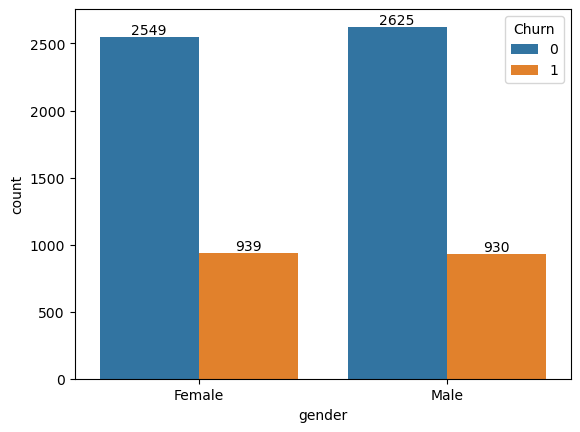

In [91]:
# Churn Distribution Across Gender
ax = sns.countplot(data=churn_data, x='gender', hue='Churn')
ax.bar_label(ax.containers[0], color = "Black")
ax.bar_label(ax.containers[1], color = "Black")
churn_data[['gender', 'Churn']].groupby(['gender']).mean().sort_values(by='Churn')

From plot, we see that gender has a low significance on churn and male and female churn at equal rate

,Churn
SeniorCitizen,
0,0.236062
1,0.416813


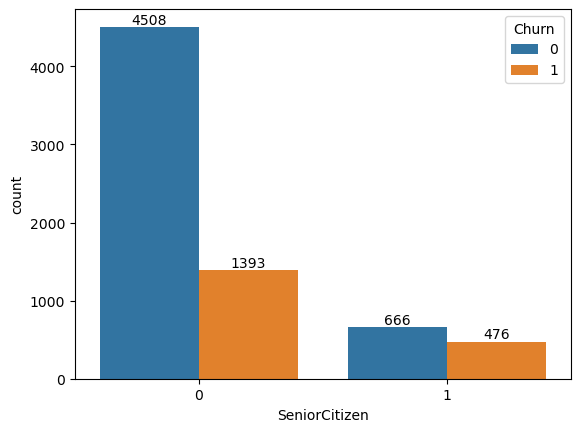

In [90]:
# Churn Distribution Across SeniorCitizen
ax = sns.countplot(data=churn_data, x='SeniorCitizen', hue='Churn')
ax.bar_label(ax.containers[0], color = "Black")
ax.bar_label(ax.containers[1], color = "Black")
churn_data[['SeniorCitizen', 'Churn']].groupby(['SeniorCitizen']).mean().sort_values(by='Churn')

From plot, we see that SeniorCitizen churn at a higher rate than non SeniorCitizen (hot encoding will help here)

,Churn
Partner,
Yes,0.196649
No,0.329580


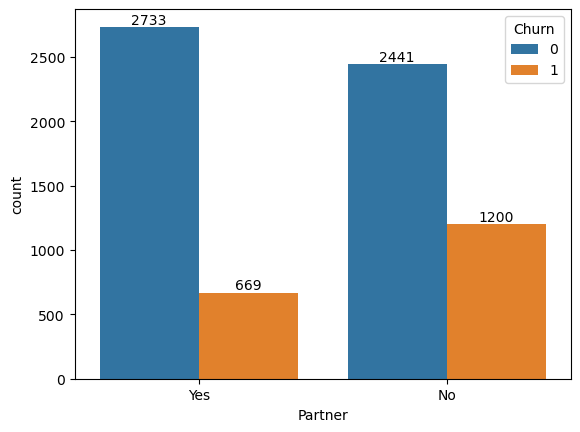

In [89]:
# Churn Distribution Across Partner
ax = sns.countplot(data=churn_data, x='Partner', hue='Churn')
ax.bar_label(ax.containers[0], color = "Black")
ax.bar_label(ax.containers[1], color = "Black")
churn_data[['Partner', 'Churn']].groupby(['Partner']).mean().sort_values(by='Churn')

From plot, we see that Partner = 'No' churn at a higher rate than Partner = 'Yes' (hot encoding will help here)

,Churn
Dependents,
Yes,0.154502
No,0.312791


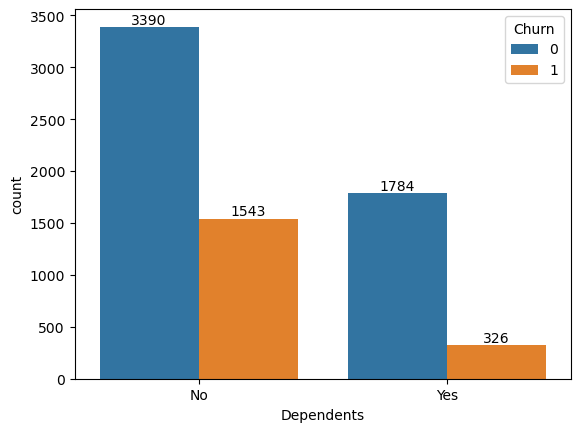

In [88]:
# Churn Distribution Across Dependents
ax = sns.countplot(data=churn_data, x='Dependents', hue='Churn')
ax.bar_label(ax.containers[0], color = "Black")
ax.bar_label(ax.containers[1], color = "Black")
churn_data[['Dependents', 'Churn']].groupby(['Dependents']).mean().sort_values(by='Churn')

From plot, we see that Dependents = 'No' churn at a higher rate than Dependents = 'Yes' (hot encoding will help here)

,Churn
PhoneService,
No,0.249267
Yes,0.267096


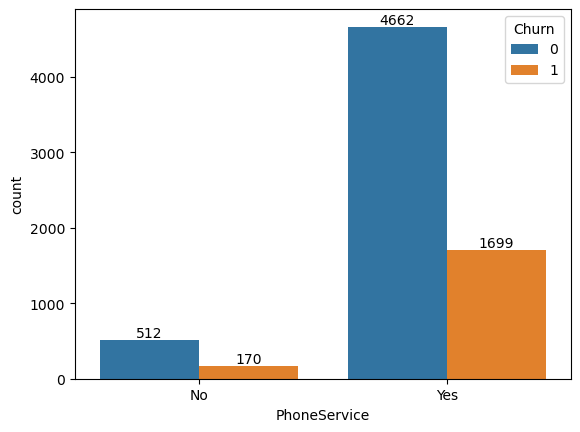

In [87]:
# Churn Distribution Across PhoneService
ax = sns.countplot(data=churn_data, x='PhoneService', hue='Churn')
ax.bar_label(ax.containers[0], color = "Black")
ax.bar_label(ax.containers[1], color = "Black")
churn_data[['PhoneService', 'Churn']].groupby(['PhoneService']).mean().sort_values(by='Churn')

From plot, we see that PhoneService = Yes and No both have similar churn rate

,Churn
MultipleLines,
No phone service,0.249267
No,0.250442
Yes,0.286099


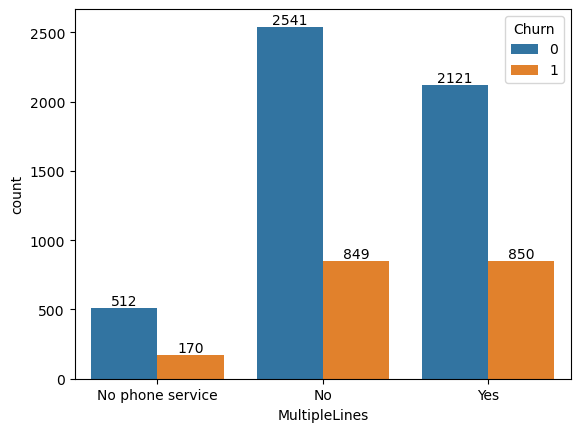

In [86]:
# Churn Distribution Across MultipleLines
ax = sns.countplot(data=churn_data, x='MultipleLines', hue='Churn')
ax.bar_label(ax.containers[0], color = "Black")
ax.bar_label(ax.containers[1], color = "Black")
churn_data[['MultipleLines', 'Churn']].groupby(['MultipleLines']).mean().sort_values(by='Churn')

From plot, we see that MultipleLines for all values have similar churn rates

,Churn
InternetService,
No,0.074050
DSL,0.189591
Fiber optic,0.418928


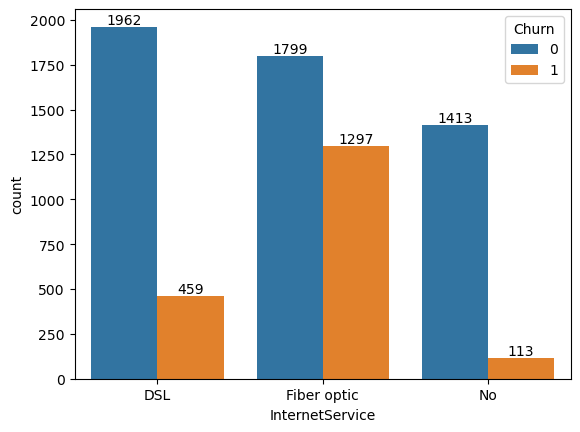

In [92]:
# Churn Distribution Across InternetService
ax = sns.countplot(data=churn_data, x='InternetService', hue='Churn')
ax.bar_label(ax.containers[0], color = "Black")
ax.bar_label(ax.containers[1], color = "Black")
churn_data[['InternetService', 'Churn']].groupby(['InternetService']).mean().sort_values(by='Churn')

From plot, we see that InternetService = 'Fiber optic' has significantly higher churn rate (hot encoding will help here)

,Churn
Contract,
Two year,0.028319
One year,0.112695
Month-to-month,0.427097


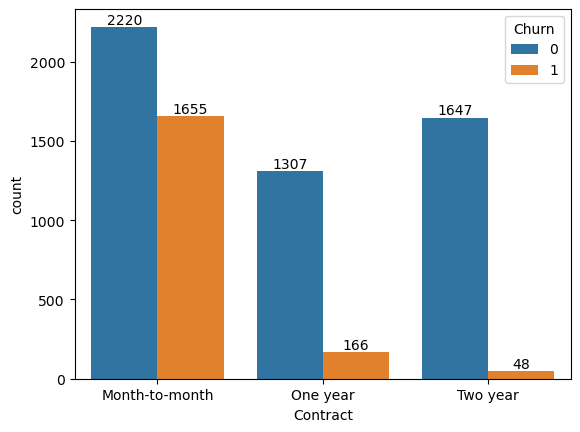

In [93]:
# Churn Distribution Across Contract
ax = sns.countplot(data=churn_data, x='Contract', hue='Churn')
ax.bar_label(ax.containers[0], color = "Black")
ax.bar_label(ax.containers[1], color = "Black")
churn_data[['Contract', 'Churn']].groupby(['Contract']).mean().sort_values(by='Churn')

From plot, we see that Contract = 'Month-to-month' has significantly higher churn rate (hot encoding will help here)

,Churn
PaperlessBilling,
No,0.163301
Yes,0.335651


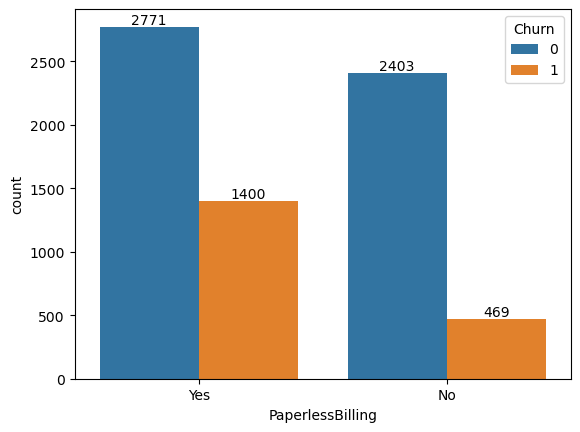

In [95]:
# Churn Distribution Across PaperlessBilling
ax = sns.countplot(data=churn_data, x='PaperlessBilling', hue='Churn')
ax.bar_label(ax.containers[0], color = "Black")
ax.bar_label(ax.containers[1], color = "Black")
churn_data[['PaperlessBilling', 'Churn']].groupby(['PaperlessBilling']).mean().sort_values(by='Churn')

From plot, we see that PaperlessBilling = 'Yes' has significantly higher churn rate (hot encoding will help here)

,Churn
PaymentMethod,
Credit card (automatic),0.152431
Bank transfer (automatic),0.167098
Mailed check,0.191067
Electronic check,0.452854


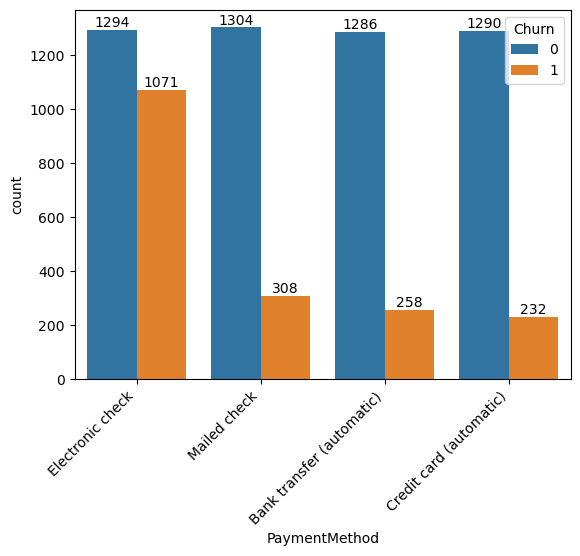

In [97]:
# Churn Distribution Across PaymentMethod
ax = sns.countplot(data=churn_data, x='PaymentMethod', hue='Churn')
plt.xticks(rotation=45, ha="right")
ax.bar_label(ax.containers[0], color = "Black")
ax.bar_label(ax.containers[1], color = "Black")
churn_data[['PaymentMethod', 'Churn']].groupby(['PaymentMethod']).mean().sort_values(by='Churn')

From plot, we see that PaymentMethod = 'Electronic check' has significantly higher churn rate

In [98]:
churn_data.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6952,Female,0,No,No,48,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),107.40,5121.30,1
3079,Female,0,No,No,4,Yes,No,DSL,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),68.65,261.25,1
4039,Male,0,No,No,7,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,94.10,701.30,0
2707,Male,0,No,No,3,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,98.70,293.65,1
1329,Female,0,Yes,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),19.40,1496.45,0


,Churn
TechSupport,
No internet service,0.074050
Yes,0.151663
No,0.416355


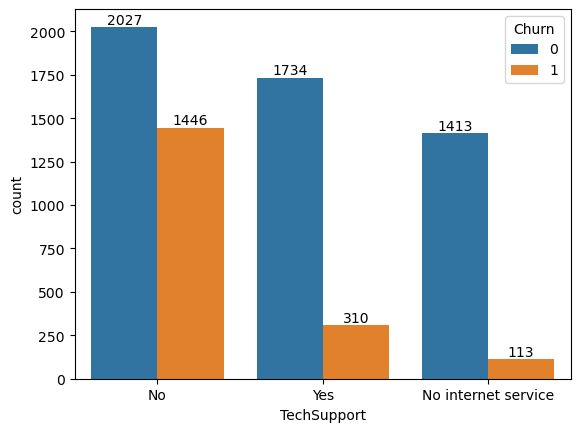

In [99]:
# Churn Distribution Across TechSupport
ax = sns.countplot(data=churn_data, x='TechSupport', hue='Churn')
ax.bar_label(ax.containers[0], color = "Black")
ax.bar_label(ax.containers[1], color = "Black")
churn_data[['TechSupport', 'Churn']].groupby(['TechSupport']).mean().sort_values(by='Churn')

From plot, we see that TechSupport = 'No' has significantly higher churn rate

### Feature Engineering
- Hot Encoding
- Bucketing

In [136]:
# We will hot-encode following columns based on EDA above:
# SeniorCitizen
# Partner
# Dependents
# InternetService
# Contract
# PaperlessBilling
# PaymentMethod
# TechSupport

hot_encoded_columns = [
    'SeniorCitizen', 
    'Partner', 
    'Dependents', 
    'InternetService', 
    'Contract', 
    'PaperlessBilling', 
    'PaymentMethod',
    'TechSupport'
]
churn_data_hot_encoded = pd.get_dummies(churn_data, columns=hot_encoded_columns, drop_first=True)
churn_data_hot_encoded.sample(5)

,gender,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,StreamingTV,StreamingMovies,MonthlyCharges,...,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TechSupport_No internet service,TechSupport_Yes
2869,Female,6,Yes,No,No,No,No,Yes,Yes,91.10,...,1,0,0,0,1,0,1,0,0,0
6861,Female,14,Yes,Yes,No,No,No,Yes,No,91.65,...,1,0,0,0,1,0,1,0,0,1
2885,Male,67,Yes,Yes,Yes,Yes,Yes,Yes,Yes,116.10,...,1,0,0,1,1,1,0,0,0,1
2022,Female,16,Yes,No,No,Yes,No,No,Yes,86.25,...,1,0,0,0,1,0,1,0,0,0
3292,Female,5,No,No phone service,No,Yes,No,Yes,Yes,50.95,...,0,0,0,0,1,1,0,0,0,0


In [137]:
# Bucket 'tenure'

def bucket_tenure(tenure):
    if tenure >= 0 and tenure <= 12:
        return "<1"
    elif tenure > 12 and tenure <= 24:
        return "1-2"
    elif tenure > 24 and tenure <= 36:
        return "2-3"
    elif tenure > 36 and tenure <= 48:
        return "3-4"
    elif tenure > 48 and tenure <= 60:
        return "4-5"
    else:
        return ">5"

churn_data_hot_encoded["tenure_bucketed"] = churn_data_hot_encoded["tenure"].apply(bucket_tenure)
churn_data_hot_encoded.sample(5)

,gender,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,StreamingTV,StreamingMovies,MonthlyCharges,...,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TechSupport_No internet service,TechSupport_Yes,tenure_bucketed
3845,Male,4,Yes,No,No,No,Yes,No,No,73.90,...,0,0,0,1,0,1,0,0,0,<1
4860,Male,13,No,No phone service,Yes,Yes,No,No,No,40.55,...,0,0,1,0,0,0,1,0,1,1-2
3037,Male,32,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,20.35,...,1,1,0,0,1,0,0,1,0,2-3
6001,Female,1,No,No phone service,No,No,No,No,No,24.90,...,0,0,0,1,0,0,1,0,0,<1
1799,Female,10,Yes,Yes,Yes,No,No,Yes,Yes,98.70,...,0,0,0,1,0,1,0,0,0,<1


In [138]:
churn_data_hot_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7043 non-null   object 
 1   tenure                                 7043 non-null   int64  
 2   PhoneService                           7043 non-null   object 
 3   MultipleLines                          7043 non-null   object 
 4   OnlineSecurity                         7043 non-null   object 
 5   OnlineBackup                           7043 non-null   object 
 6   DeviceProtection                       7043 non-null   object 
 7   StreamingTV                            7043 non-null   object 
 8   StreamingMovies                        7043 non-null   object 
 9   MonthlyCharges                         7043 non-null   float64
 10  TotalCharges                           7043 non-null   float64
 11  Chur

### Model Building

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

features = [
    'SeniorCitizen_1', 
    'Partner_Yes',
    'Dependents_Yes',
    'InternetService_Fiber optic',
    'InternetService_No',
    'Contract_One year',
    'Contract_Two year',
    'PaperlessBilling_Yes',
    'PaymentMethod_Credit card (automatic)',
    'PaymentMethod_Electronic check',
    'PaymentMethod_Mailed check',
    'TechSupport_No internet service'
    
]  # Features to use in the formula
target = 'Churn'  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    churn_data_hot_encoded[features], 
    churn_data_hot_encoded[target], 
    test_size=0.25, 
    random_state=123
)

# Create the logistic regression model using the formula
model = LogisticRegression(random_state=123, max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("Confusion matrix:\n", conf_matrix)
print("Classification report:\n", classification_rep)

Accuracy: 0.7654741624077229
Confusion matrix:
 [[1124  138]
 [ 275  224]]
Classification report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84      1262
           1       0.62      0.45      0.52       499

    accuracy                           0.77      1761
   macro avg       0.71      0.67      0.68      1761
weighted avg       0.75      0.77      0.75      1761

